# **Clustering Neighborhoods in Erfurt**

## 1. Introduction and task

I have a friend who works in nursing. She would like to change her career and move her living and working area to Erfurt, because she has a boyfriend there. <br> Erfurt is the capital of the Free State of Thuringia. With a good 214,000 inhabitants (2018),it is also the largest city in Thuringia and, along with Jena and Gera, one of the state's three major centers. In addition to the state authorities, the most important institutions are the Federal Labor Court, the University of Erfurt and the University of Applied Sciences, the Catholic Diocese of Erfurt, whose cathedral is Erfurt Cathedral, and the Regional Church Office of the Protestant Church in Central Germany. In addition to the Krämerbrücke, the unique ensemble of the cathedral and the Severi Church is one of the city's main sights. In addition, the city has an almost three square kilometer medieval-style Altstadt center with about 25 parish churches, the baroque citadel Petersberg, the oldest preserved synagogue in Central Europe and numerous half-timbered and other town houses. <br>
<br>
My friend has taken a job with a temporary employment agency that hires out nursing staff to hospitals or nursing homes depending on the demand there. 
So it is quite possible that she will do a shift at hospital A one day and at nursing home B the next. 
Her new employer has provided her with a list of names and addresses of the institutions that might be suitable for her. She must specify at least 3 institutions in which she would like to work; the upper limit is 5.
My friend and her boyfriend would like to have an apartment together, preferably in the same part of town as my friend's new places of work, since she does not own a car and depends on public transportation - or her bicycle. Her boyfriend already owns an apartment in Löbervorstadt, but is willing to move since he owns a car and works outside of Erfurt anyway. 
If possible, there should be some restaurants, supermarkets and other shopping facilities near the working places, so that she can go shopping or have something to eat after or even sometimes before work. Also some places of interest nearby would be nice. <br>
<br>
My job is to figure out which part of town is best to work and live in based on her desired criteria as well as the location of the new places of work.

## 2. DATA

## *2.1 Download all the dependencies that will be needed.*

In [1]:
!pip install wikipedia
!pip install folium
!pip install geopy
!pip install geopandas
!pip install geojson
!pip install OSMPythonTools
!pip install reverse_geocoder

In [2]:
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import wikipedia as wp
import requests
from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopandas as gpd

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

#Importing the required modules
from geopy.extra.rate_limiter import RateLimiter

print('Libraries imported.')

Libraries imported.


To get an overview of all existing districts of Erfurt, I import the table from "https://de.wikipedia.org/wiki/Liste_der_Ortsteile_von_Erfurt"as Erfurt_borough_wiki.
Next, I remove all superfluous columns for the sake of clarity. At the end it shows that Erfurt has 53 districts/ suburbs. In the further analysis I would like to determine the distribution of the institutions on the individual districts. Ideal for my friend would be, if there are at least 3 institutions in one district, or if at least 3 institutions are close to each other, even if the districts are different.

## *1.2 Download and Explore Dataset*

In [3]:
# load data which include the suburbs/ districts of Erfurt from Wikipedia to get an overview
df= pd.read_html('https://de.wikipedia.org/wiki/Liste_der_Ortsteile_von_Erfurt', header=0)
Erfurt_borough_wiki = df[0]

Erfurt_borough_wiki.columns = ('district', 'area1', 'population', 'km2', 'Population_Density_km2', 'structur', 'year', 'district2', 'houses', 'flats', 'empty')
Erfurt_borough_wiki.head()

,district,area1,population,km2,Population_Density_km2,structur,year,district2,houses,flats,empty
0,Alach,NaN,1.000,101,99.000,dörflich,1994.0,Ja,270.000,361.000,22
1,Altstadt,NaN,17.980,244,7.369,städtisch,NaN,Nein,1.783,10.433,76
2,Andreasvorstadt,NaN,16.020,285,5.621,städtisch,NaN,Nein,1.410,9.366,99
3,Azmannsdorf,NaN,339.000,425,80.000,dörflich,1994.0,Ja,120.000,133.000,83
4,Berliner Platz,NaN,5.844,48,12.175,Plattenbau,NaN,Ja,161.000,3.771,43


In [4]:
# Drop the columns I don´t need.
Erfurt_district = Erfurt_borough_wiki.drop(['area1', 'population', 'km2', 'Population_Density_km2', 'structur', 'year', 'district2', 'houses', 'flats', 'empty'],axis=1)
Erfurt_district
# Erfurt has 53 suburbs / districts 

,district
0,Alach
1,Altstadt
2,Andreasvorstadt
3,Azmannsdorf
4,Berliner Platz
5,Bindersleben
6,Bischleben-Stedten
7,Brühlervorstadt
8,Büßleben
9,Daberstedt


Here you can see the allocation of the suburbs:<br> 
source: https://de.wikipedia.org/wiki/Liste_der_Ortsteile_von_Erfurt#/media/Datei:Erfurt-Bev%C3%B6lkerungsdichte.png

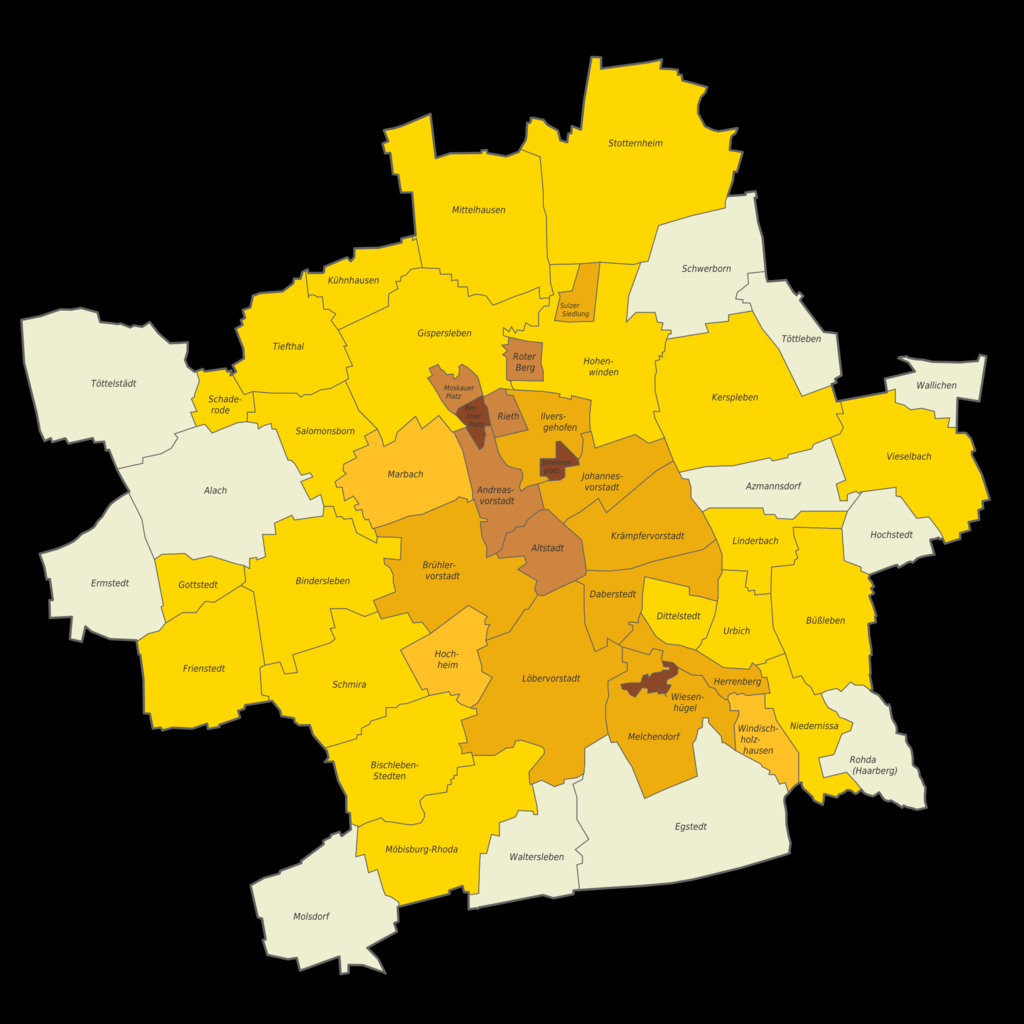

In the next step I import the Nursing_and_care_home.csv file of my friend as dataframe Nursing_and_care_home, which contains the names of the hospitals and nursing homes and the addresses. There are 25 rows, respectively 25 institutions and 2 columns.

In [5]:
# load the data with name and address of Nursing and care homes and hospitals in Erfurt
Nursing_and_care_home = pd.read_csv('Nursing_and_care_home.csv',sep=';', header=0, index_col=False) 

In [6]:
Nursing_and_care_home.head()

,name,addr
0,Helios Klinikum Erfurt,"Nordhäuser Straße 74,99089,Erfurt"
1,"Katholisches Krankenhaus ""St. Johann Nepomuk"" ...","Haarbergstraße 72,99097,Erfurt"
2,"Alloheim Senioren-Residenz ""Am Hirschgarten""","Neuwerkstraße 24,99084,Erfurt"
3,"ASB Senioren- und Pflegeheim ""Georg Boock""","Rankestraße 59,99096,Erfurt"
4,Augusta-Viktoria-Stift Alten- und Pflegeheim,"Hospitalplatz 15a,99084,Erfurt"


In [7]:
Nursing_and_care_home.shape

(24, 2)

Using the geolocator query, I get the latitude and longitude coordinates and the corresponding location. It turns out that the addresses fit, but not always the names. So there is a deviation, but I can neglect it. My friend got the data from her employer, so that I can assume that name and address are correct and the data stock regarding the names, which were delivered by geolocator, is obviously not (anymore) up to date.

In [8]:
#Creating a dataframe with address of locations I want to reterive
locat = Nursing_and_care_home['addr']
df = pd.DataFrame({'add': locat})
 
#Creating an instance of Nominatim Class
geolocator = Nominatim(user_agent="my_request")
 
#applying the rate limiter wrapper
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
 
#Applying the method to pandas DataFrame
df['location'] = df['add'].apply(geocode)
df['Lat'] = df['location'].apply(lambda x: x.latitude if x else None)
df['Lon'] = df['location'].apply(lambda x: x.longitude if x else None)
df.head()

,add,location,Lat,Lon
0,"Nordhäuser Straße 74,99089,Erfurt","(Helios Klinikum Erfurt, 74, Nordhäuser Straße...",50.992685,11.013446
1,"Haarbergstraße 72,99097,Erfurt","(Katholisches Krankenhaus ""St. Johann Nepomuk""...",50.947735,11.084226
2,"Neuwerkstraße 24,99084,Erfurt","(Apotheke am Hirschgarten, 24, Neuwerkstraße, ...",50.972417,11.026811
3,"Rankestraße 59,99096,Erfurt","(59, Rankestraße, Löbervorstadt, Erfurt, Thüri...",50.961353,11.028842
4,"Hospitalplatz 15a,99084,Erfurt","(Kita & Pflegeheim ""Augusta-Viktoria-Stift"", 1...",50.981793,11.036660


In a next step I combine the columns Lat and Lon to an additional column latlon to get the column full_adress for the single institutions via the geolocator.reverse query afterwards. This column contains, among other things, the information in which city district the corresponding institutions are located.

In [9]:
# add column latlon 
df['latlon'] = df['Lat'].map(str) + ','+ df['Lon'].map(str)
df['latlon'][0]
df.head()

,add,location,Lat,Lon,latlon
0,"Nordhäuser Straße 74,99089,Erfurt","(Helios Klinikum Erfurt, 74, Nordhäuser Straße...",50.992685,11.013446,"50.99268485,11.01344586977623"
1,"Haarbergstraße 72,99097,Erfurt","(Katholisches Krankenhaus ""St. Johann Nepomuk""...",50.947735,11.084226,"50.94773485,11.084226172724772"
2,"Neuwerkstraße 24,99084,Erfurt","(Apotheke am Hirschgarten, 24, Neuwerkstraße, ...",50.972417,11.026811,"50.972417,11.0268113"
3,"Rankestraße 59,99096,Erfurt","(59, Rankestraße, Löbervorstadt, Erfurt, Thüri...",50.961353,11.028842,"50.96135325,11.028842394954673"
4,"Hospitalplatz 15a,99084,Erfurt","(Kita & Pflegeheim ""Augusta-Viktoria-Stift"", 1...",50.981793,11.036660,"50.9817928,11.036660451209475"


In [10]:
locator = Nominatim(user_agent='myGeocoder', timeout=10)
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)
print('done')

done


In [11]:
# get address data from geolocator
df['full_adress'] = None
i = 0
while i < 24:
    location = geolocator.reverse(df['latlon'][i])
    #print(location.address)
    df.loc[i,['full_adress']]= location.address
    i += 1
df.head()

,add,location,Lat,Lon,latlon,full_adress
0,"Nordhäuser Straße 74,99089,Erfurt","(Helios Klinikum Erfurt, 74, Nordhäuser Straße...",50.992685,11.013446,"50.99268485,11.01344586977623","Helios Klinikum Erfurt, 74, Nordhäuser Straße,..."
1,"Haarbergstraße 72,99097,Erfurt","(Katholisches Krankenhaus ""St. Johann Nepomuk""...",50.947735,11.084226,"50.94773485,11.084226172724772","Katholisches Krankenhaus ""St. Johann Nepomuk"",..."
2,"Neuwerkstraße 24,99084,Erfurt","(Apotheke am Hirschgarten, 24, Neuwerkstraße, ...",50.972417,11.026811,"50.972417,11.0268113","Apotheke am Hirschgarten, 24, Neuwerkstraße, A..."
3,"Rankestraße 59,99096,Erfurt","(59, Rankestraße, Löbervorstadt, Erfurt, Thüri...",50.961353,11.028842,"50.96135325,11.028842394954673","ASB- Seniorenheim ""Georg Book"", Grimmstraße, L..."
4,"Hospitalplatz 15a,99084,Erfurt","(Kita & Pflegeheim ""Augusta-Viktoria-Stift"", 1...",50.981793,11.036660,"50.9817928,11.036660451209475","Kita & Pflegeheim ""Augusta-Viktoria-Stift"", 15..."


Afterwards I make a join with the dataframe Nursing_and_care_home and split the column full_adress. I remove columns that I do not need. 
In the end, street, suburb and city remain from the full_adress column. At this point, however, shifts show up because the data supplied via reverse contains a different amount of information.

In [12]:
# split full address in single data
df[['Name','HSNR','street','suburb','city','state','PLZ','country']] = df['full_adress'].str.split(',', 7, expand=True)
df =df.drop(['HSNR','add', 'location', 'state','PLZ','country','Name'],axis=1)
df.head()

,Lat,Lon,latlon,full_adress,street,suburb,city
0,50.992685,11.013446,"50.99268485,11.01344586977623","Helios Klinikum Erfurt, 74, Nordhäuser Straße,...",Nordhäuser Straße,Andreasvorstadt,Erfurt
1,50.947735,11.084226,"50.94773485,11.084226172724772","Katholisches Krankenhaus ""St. Johann Nepomuk"",...",Haarbergstraße,Melchendorf,Urbich
2,50.972417,11.026811,"50.972417,11.0268113","Apotheke am Hirschgarten, 24, Neuwerkstraße, A...",Neuwerkstraße,Altstadt,Erfurt
3,50.961353,11.028842,"50.96135325,11.028842394954673","ASB- Seniorenheim ""Georg Book"", Grimmstraße, L...",Löbervorstadt,Erfurt,Thüringen
4,50.981793,11.036660,"50.9817928,11.036660451209475","Kita & Pflegeheim ""Augusta-Viktoria-Stift"", 15...",Hospitalplatz,Altstadt,Erfurt


In [13]:
# join the 2 dataframes and drop columns not needed
Nursing_and_care_home_new = df.join(Nursing_and_care_home)
Nursing_and_care_home_new = Nursing_and_care_home_new.drop(['full_adress','addr'],axis=1)
Nursing_and_care_home_new = Nursing_and_care_home_new[['name','Lat','Lon','latlon','street','suburb','city']]
Nursing_and_care_home_new

,name,Lat,Lon,latlon,street,suburb,city
0,Helios Klinikum Erfurt,50.992685,11.013446,"50.99268485,11.01344586977623",Nordhäuser Straße,Andreasvorstadt,Erfurt
1,"Katholisches Krankenhaus ""St. Johann Nepomuk"" ...",50.947735,11.084226,"50.94773485,11.084226172724772",Haarbergstraße,Melchendorf,Urbich
2,"Alloheim Senioren-Residenz ""Am Hirschgarten""",50.972417,11.026811,"50.972417,11.0268113",Neuwerkstraße,Altstadt,Erfurt
3,"ASB Senioren- und Pflegeheim ""Georg Boock""",50.961353,11.028842,"50.96135325,11.028842394954673",Löbervorstadt,Erfurt,Thüringen
4,Augusta-Viktoria-Stift Alten- und Pflegeheim,50.981793,11.036660,"50.9817928,11.036660451209475",Hospitalplatz,Altstadt,Erfurt
5,Augusta-Viktoria-Stift Pflegeheim,50.961271,11.032657,"50.9612709,11.0326575",Löbervorstadt,Erfurt,Thüringen
6,AWO-Altenpflegeheim Haus zu den vier Jahreszeiten,50.981881,11.035409,"50.9818814,11.03540916526946",Altstadt,Erfurt,Thüringen
7,AZURIT Seniorenzentrum Erfurt,50.980172,11.046428,"50.9801717,11.0464282",Äußere Krämpfervorstadt,Krämpfervorstadt,Erfurt
8,Deutschordens-Seniorenhaus Erfurt,51.006559,11.010863,"51.006558749999996,11.010862517930299",Vilniuser Straße,Rieth,Erfurt
9,Diakoniestiftung Weimar - Seniorenzentrum Haus...,50.982049,11.021522,"50.982049,11.021522",Andreasviertel,Altstadt,Erfurt


In the columns street and city are partly suburbs, in suburb partly Erfurt, which should actually be in city and city contains partly the name of the state, so Thuringia.
At this point this is not bad, because I know the names of the suburbs from the Wikipedia table, so I can correct this accordingly. In addition, I rename the umlauts, so that I get later no problems because of the "language barrier".

In [14]:
# as the data for suburb are partly not in the correct columns, which is related to the data delivery via geolocater, 
# these data are corrected. I also change the umlauts to avoid problems with alphabetical sorting.
Nursing_and_care_home_new = Nursing_and_care_home_new.drop(['street'],axis=1)
Nursing_and_care_home_new.loc[[3,5,10,19,21], ['suburb']] = "Loebervorstadt"
Nursing_and_care_home_new.loc[[6,16], ['suburb']] = "Altstadt"
Nursing_and_care_home_new.loc[[13,15], ['suburb']] = "Bruehlervorstadt"
Nursing_and_care_home_new.loc[[17], ['suburb']] = "Ilversgehofen"
Nursing_and_care_home_new.loc[[18], ['suburb']] = 'Daberstedt'
Nursing_and_care_home_new.loc[[14], ['suburb']] = 'Wiesenhuegel'
Nursing_and_care_home_new.loc[[7], ['suburb']] = 'Kraempfervorstadt'
Nursing_and_care_home_new = Nursing_and_care_home_new.drop(['city','latlon'],axis=1)
Nursing_and_care_home_new

,name,Lat,Lon,suburb
0,Helios Klinikum Erfurt,50.992685,11.013446,Andreasvorstadt
1,"Katholisches Krankenhaus ""St. Johann Nepomuk"" ...",50.947735,11.084226,Melchendorf
2,"Alloheim Senioren-Residenz ""Am Hirschgarten""",50.972417,11.026811,Altstadt
3,"ASB Senioren- und Pflegeheim ""Georg Boock""",50.961353,11.028842,Loebervorstadt
4,Augusta-Viktoria-Stift Alten- und Pflegeheim,50.981793,11.036660,Altstadt
5,Augusta-Viktoria-Stift Pflegeheim,50.961271,11.032657,Loebervorstadt
6,AWO-Altenpflegeheim Haus zu den vier Jahreszeiten,50.981881,11.035409,Altstadt
7,AZURIT Seniorenzentrum Erfurt,50.980172,11.046428,Kraempfervorstadt
8,Deutschordens-Seniorenhaus Erfurt,51.006559,11.010863,Rieth
9,Diakoniestiftung Weimar - Seniorenzentrum Haus...,50.982049,11.021522,Altstadt


Using groupby, I would like to find out how many institutions are located in each suburb. At this point, however, it appears that there is a problem with blanks, since some of the suburbs are indented in the output and are therefore not added up correctly. So I remove the spaces and have the overview generated again. This time it works. It shows that both the Altstadt and the Löbervorstadt each have 5 facilities, the Andreas- and Brühlervorstadt and Ilgershofen each have 2, and the remaining 8 suburbs each have only 1 . 

In [15]:
freq = Nursing_and_care_home_new.groupby(['suburb']).count() 
print(freq)

                   name  Lat  Lon
suburb                           
 Altstadt             3    3    3
 Andreasvorstadt      2    2    2
 Ilversgehofen        1    1    1
 Marbach              1    1    1
 Melchendorf          1    1    1
 Rieth                1    1    1
 Roter Berg           1    1    1
 Vieselbach           1    1    1
Altstadt              2    2    2
Bruehlervorstadt      2    2    2
Daberstedt            1    1    1
Ilversgehofen         1    1    1
Kraempfervorstadt     1    1    1
Loebervorstadt        5    5    5
Wiesenhuegel          1    1    1


In [16]:
freq = Nursing_and_care_home_new['suburb'].value_counts() 
print(freq)

Loebervorstadt       5
 Altstadt            3
Altstadt             2
Bruehlervorstadt     2
 Andreasvorstadt     2
 Vieselbach          1
 Marbach             1
 Roter Berg          1
 Ilversgehofen       1
Wiesenhuegel         1
Kraempfervorstadt    1
Daberstedt           1
 Melchendorf         1
 Rieth               1
Ilversgehofen        1
Name: suburb, dtype: int64


In [17]:
# In the output via count, you can see that there is obviously a problem with spaces. so i remove them
Nursing_and_care_home_new['suburb'] = Nursing_and_care_home_new['suburb'].str.strip()
Nursing_and_care_home_new.head()

,name,Lat,Lon,suburb
0,Helios Klinikum Erfurt,50.992685,11.013446,Andreasvorstadt
1,"Katholisches Krankenhaus ""St. Johann Nepomuk"" ...",50.947735,11.084226,Melchendorf
2,"Alloheim Senioren-Residenz ""Am Hirschgarten""",50.972417,11.026811,Altstadt
3,"ASB Senioren- und Pflegeheim ""Georg Boock""",50.961353,11.028842,Loebervorstadt
4,Augusta-Viktoria-Stift Alten- und Pflegeheim,50.981793,11.036660,Altstadt


In [18]:
freq = Nursing_and_care_home_new['suburb'].value_counts() 
print(freq)
# here we can see the suburbs and their distributions to the Nursing and care homes and hospitals in Erfurt
# Below I look at the suburbs with the most nursing homes and hospitals: Altstadt and Loebervorstadt

Altstadt             5
Loebervorstadt       5
Bruehlervorstadt     2
Andreasvorstadt      2
Ilversgehofen        2
Vieselbach           1
Melchendorf          1
Wiesenhuegel         1
Rieth                1
Kraempfervorstadt    1
Marbach              1
Roter Berg           1
Daberstedt           1
Name: suburb, dtype: int64


In [19]:
# Sorting suburb in alphabetical order
Nurse_Care = Nursing_and_care_home_new.sort_values(by='suburb',ascending=True)
Nurse_Care.reset_index(drop=True, inplace=True)
Nurse_Care

,name,Lat,Lon,suburb
0,"Alloheim Senioren-Residenz ""Am Hirschgarten""",50.972417,11.026811,Altstadt
1,Augusta-Viktoria-Stift Alten- und Pflegeheim,50.981793,11.036660,Altstadt
2,AWO-Altenpflegeheim Haus zu den vier Jahreszeiten,50.981881,11.035409,Altstadt
3,Kath. Altenheim Carolinenstift Erfurt,50.978265,11.032025,Altstadt
4,Diakoniestiftung Weimar - Seniorenzentrum Haus...,50.982049,11.021522,Altstadt
5,Helios Klinikum Erfurt,50.992685,11.013446,Andreasvorstadt
6,"VAMED Senioren- und Pflegeheim Erfurt ""Haus am...",50.989737,11.015982,Andreasvorstadt
7,K&S Seniorenresidenz Erfurt,50.974929,11.016781,Bruehlervorstadt
8,Haus im Brühl Erfurt,50.973914,11.016659,Bruehlervorstadt
9,Residenz Ambiente Erfurt,50.964932,11.040838,Daberstedt


In the next step, I create a map of Erfurt with the help of Nominatim and k-means and display the hospitals and nursing homes to get an overview of the location. Here you can see that some of the facilities are relatively scattered and others are close to each other. In Löbervorstadt, for example, 4 institutions are located close to each other.

In [20]:
address = 'Erfurt, Thuringia'

geolocator = Nominatim(user_agent="Erfurt")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Erfurt are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Erfurt are 50.9777974, 11.0287364.


In [21]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# create map of Erfurt using latitude and longitude values
map_Erfurt = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers to map
X = Nurse_Care['Lat']
Y = Nurse_Care['Lon']
Z = np.stack((X, Y), axis=1)

kmeans = KMeans(n_clusters=13, random_state=0).fit(Z)

clusters = kmeans.labels_
colors = ['red', 'green', 'blue','yellow','orange','darkpurple','pink','cadetblue','lightred','darkblue','darkgreen','purple','lightgreen']
Nurse_Care ['Cluster'] = clusters

for latitude, longitude, name, cluster in zip(Nurse_Care['Lat'], Nurse_Care['Lon'], Nurse_Care['name'], Nurse_Care['Cluster']):
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_Erfurt)  

map_Erfurt

![Alt-Text](Institutions.PNG)

The employer's requirement for my friend was to choose at least 3 facilities where she would like to work. <br> In the map, it is easy to see that both the Altstadt and the Löbervorstadt are good candidates to work in; moreover, her boyfriend already owns an apartment in the Löbervorstadt. 
In Löbervorstadt, the DRK Christianenheim, the Augusta-Vikoria-Stift nursing home, and the ASB senior citizens' and nursing home are very close to each other. The St. Elisabeth home is a little further away, but still closer to each other than the other care facilities. The "Haus Am Steigerwald" senior citizens' and nursing home is part of Löbervorstadt, but is still a little further away. The Residenz Ambiente is located in Daberstedt but closer to the first four named than the "Haus Am Steigerwald". <br>
In the Altstadt, the AWO nursing home and the Augusta-Viktoria-Stift retirement and nursing home are close to each other, and the Carolinenstift Erfurt catholic retirement home is a little further away. As an alternative to the latter, my friend could also opt for the AZURIT Seniorenzentrum in Krämpfervorstadt, which, however, would no longer fit her requirement. Also the K&S Seniorenresidenz which is located close to the "Haus am Brühl" would be an option in connection with the Alloheim Senioren-Residenz "Am Hirschgarten", however, this does not correspond to the wishes either. <br>
For these reasons, I limit my further consideration of the districts to the Löbervorstadt and the Altstadt.<br>
Therefore I create the new dataframe AltLoeber_data, which contains only the 5 facilities of Altstadt and Löbervorstadt.

In [22]:
# My friend has already had an interview at the Augusta-Viktoria-Stift -Altstadt- retirement and nursing home and at the St. Elisabeth retirement and nursing home - Loebervorstadt-. 
# In addition, her boyfriend already lives in the loebervorstadt. Therefore, I will limit myself to the consideration of these two suburbs.
# Furthermore the Altstadt is the city center of Erfurt.
Altstadt_data = Nurse_Care[Nurse_Care['suburb'] == 'Altstadt'].reset_index(drop=True)
Altstadt_data.head()

,name,Lat,Lon,suburb,Cluster
0,"Alloheim Senioren-Residenz ""Am Hirschgarten""",50.972417,11.026811,Altstadt,5
1,Augusta-Viktoria-Stift Alten- und Pflegeheim,50.981793,11.036660,Altstadt,7
2,AWO-Altenpflegeheim Haus zu den vier Jahreszeiten,50.981881,11.035409,Altstadt,7
3,Kath. Altenheim Carolinenstift Erfurt,50.978265,11.032025,Altstadt,7
4,Diakoniestiftung Weimar - Seniorenzentrum Haus...,50.982049,11.021522,Altstadt,11


In [23]:
Loebervorstadt_data=Nurse_Care[Nurse_Care['suburb'] == 'Loebervorstadt'].reset_index(drop=True)
Loebervorstadt_data

,name,Lat,Lon,suburb,Cluster
0,Augusta-Viktoria-Stift Pflegeheim,50.961271,11.032657,Loebervorstadt,3
1,"ASB Senioren- und Pflegeheim ""Georg Boock""",50.961353,11.028842,Loebervorstadt,3
2,St.-Elisabeth-Heim Alten- und Pflegeheim,50.964709,11.029748,Loebervorstadt,3
3,DRK Senioren- und Pflegeheim Christianenheim,50.961200,11.033925,Loebervorstadt,3
4,Senioren- und Pflegeheim Haus Am Steigerwald,50.960616,11.017943,Loebervorstadt,12


In [24]:
# concaternate the 2 dataframes
frames = [Loebervorstadt_data,Altstadt_data]
AltLoeber_data = pd.concat(frames)
#AltLoeber_data=Nurse_Care[Nurse_Care['suburb'] == 'Loebervorstadt'].reset_index(drop=True)
#AltLoeber_data=AltLoeber_data[Nurse_Care['suburb'] == 'Altstadt'].reset_index(drop=True)
AltLoeber_data.reset_index(drop=True, inplace=True)
AltLoeber_data

,name,Lat,Lon,suburb,Cluster
0,Augusta-Viktoria-Stift Pflegeheim,50.961271,11.032657,Loebervorstadt,3
1,"ASB Senioren- und Pflegeheim ""Georg Boock""",50.961353,11.028842,Loebervorstadt,3
2,St.-Elisabeth-Heim Alten- und Pflegeheim,50.964709,11.029748,Loebervorstadt,3
3,DRK Senioren- und Pflegeheim Christianenheim,50.961200,11.033925,Loebervorstadt,3
4,Senioren- und Pflegeheim Haus Am Steigerwald,50.960616,11.017943,Loebervorstadt,12
5,"Alloheim Senioren-Residenz ""Am Hirschgarten""",50.972417,11.026811,Altstadt,5
6,Augusta-Viktoria-Stift Alten- und Pflegeheim,50.981793,11.036660,Altstadt,7
7,AWO-Altenpflegeheim Haus zu den vier Jahreszeiten,50.981881,11.035409,Altstadt,7
8,Kath. Altenheim Carolinenstift Erfurt,50.978265,11.032025,Altstadt,7
9,Diakoniestiftung Weimar - Seniorenzentrum Haus...,50.982049,11.021522,Altstadt,11


In [25]:
CLIENT_ID = '0IOJPD1CR1OVQAUX1YGSFUSZK5P2AVXQLDFNGWHT3DWYRXEN' # your Foursquare ID
CLIENT_SECRET = 'PTLF0Z5VFPV4FJNMZ2ZE303QMNAGSFH3POQHTI2PDPCPNCFD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0IOJPD1CR1OVQAUX1YGSFUSZK5P2AVXQLDFNGWHT3DWYRXEN
CLIENT_SECRET:PTLF0Z5VFPV4FJNMZ2ZE303QMNAGSFH3POQHTI2PDPCPNCFD


In [26]:
#Create a function for the neighborhoods in EF
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
#create a new dataframe called Erfurt_venues and check if all the institutions are still there.

AltLoeber_venues = getNearbyVenues(names=AltLoeber_data['name'],
                                   latitudes=AltLoeber_data['Lat'],
                                   longitudes=AltLoeber_data['Lon']
                                  )

Augusta-Viktoria-Stift Pflegeheim
ASB Senioren- und Pflegeheim "Georg Boock"
St.-Elisabeth-Heim Alten- und Pflegeheim
DRK Senioren- und Pflegeheim Christianenheim
Senioren- und Pflegeheim Haus Am Steigerwald
Alloheim Senioren-Residenz "Am Hirschgarten"
Augusta-Viktoria-Stift Alten- und Pflegeheim
AWO-Altenpflegeheim Haus zu den vier Jahreszeiten
Kath. Altenheim Carolinenstift Erfurt
Diakoniestiftung Weimar - Seniorenzentrum Haus Andreashof


In [28]:
#Let's check the size of the resulting dataframe

print(AltLoeber_venues.shape)
AltLoeber_venues.head()

(238, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Augusta-Viktoria-Stift Pflegeheim,50.961271,11.032657,Hopfenberg,50.963485,11.028589,German Restaurant
1,Augusta-Viktoria-Stift Pflegeheim,50.961271,11.032657,Gunda-Niemann-Stirnemann-Halle,50.962170,11.035811,Skating Rink
2,Augusta-Viktoria-Stift Pflegeheim,50.961271,11.032657,Steigerwaldstadion,50.959999,11.036386,Soccer Stadium
3,Augusta-Viktoria-Stift Pflegeheim,50.961271,11.032657,Shang-Hai,50.960036,11.034275,Chinese Restaurant
4,Augusta-Viktoria-Stift Pflegeheim,50.961271,11.032657,Commagene Kebab,50.961822,11.029477,Doner Restaurant


In [29]:
#Check how many venues were returned for each neighborhood
AltLoeber_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"ASB Senioren- und Pflegeheim ""Georg Boock""",5,5,5,5,5,5
AWO-Altenpflegeheim Haus zu den vier Jahreszeiten,46,46,46,46,46,46
"Alloheim Senioren-Residenz ""Am Hirschgarten""",33,33,33,33,33,33
Augusta-Viktoria-Stift Alten- und Pflegeheim,36,36,36,36,36,36
Augusta-Viktoria-Stift Pflegeheim,8,8,8,8,8,8
DRK Senioren- und Pflegeheim Christianenheim,8,8,8,8,8,8
Diakoniestiftung Weimar - Seniorenzentrum Haus Andreashof,11,11,11,11,11,11
Kath. Altenheim Carolinenstift Erfurt,78,78,78,78,78,78
Senioren- und Pflegeheim Haus Am Steigerwald,8,8,8,8,8,8


In [30]:
# Find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(AltLoeber_venues['Venue Category'].unique())))

There are 81 uniques categories.


## *1.3 Analyze Each Neighborhood*

To analyze the two neighborhoods, I use Foursquare and take the establishments as starting points. <br> Using one-hot-encoding and narrowing down to the top 5 most common venues and the top 10 venues for each neighborhood, you can get a good overview of the two neighborhoods.

In [31]:
# one hot encoding
AltLoeber_onehot = pd.get_dummies(AltLoeber_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
AltLoeber_onehot['Neighborhood'] = AltLoeber_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [AltLoeber_onehot.columns[-1]] + list(AltLoeber_onehot.columns[:-1])
AltLoeber_onehot = AltLoeber_onehot[fixed_columns]

AltLoeber_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Basketball Court,Bavarian Restaurant,Bookstore,Breakfast Spot,Brewery,Bus Stop,Café,Castle,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Currywurst Joint,Deli / Bodega,Department Store,Doner Restaurant,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Farmers Market,Fountain,Gas Station,Gastropub,German Restaurant,Gourmet Shop,Greek Restaurant,Gym / Fitness Center,Gym Pool,Historic Site,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Liquor Store,Mediterranean Restaurant,Monastery,Music Venue,Nightclub,Noodle House,Opera House,Other Great Outdoors,Paper / Office Supplies Store,Park,Pedestrian Plaza,Plaza,Pub,Public Art,Restaurant,Sandwich Place,Seafood Restaurant,Shopping Mall,Skating Rink,Soccer Stadium,Soup Place,Spanish Restaurant,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tanning Salon,Track Stadium,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Video Store,Wine Bar,Wine Shop
0,Augusta-Viktoria-Stift Pflegeheim,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Augusta-Viktoria-Stift Pflegeheim,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Augusta-Viktoria-Stift Pflegeheim,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Augusta-Viktoria-Stift Pflegeheim,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Augusta-Viktoria-Stift Pflegeheim,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
AltLoeber_onehot.shape

(238, 82)

In [33]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
AltLoeber_grouped = AltLoeber_onehot.groupby('Neighborhood').mean().reset_index()
AltLoeber_grouped

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Basketball Court,Bavarian Restaurant,Bookstore,Breakfast Spot,Brewery,Bus Stop,Café,Castle,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Currywurst Joint,Deli / Bodega,Department Store,Doner Restaurant,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Farmers Market,Fountain,Gas Station,Gastropub,German Restaurant,Gourmet Shop,Greek Restaurant,Gym / Fitness Center,Gym Pool,Historic Site,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Liquor Store,Mediterranean Restaurant,Monastery,Music Venue,Nightclub,Noodle House,Opera House,Other Great Outdoors,Paper / Office Supplies Store,Park,Pedestrian Plaza,Plaza,Pub,Public Art,Restaurant,Sandwich Place,Seafood Restaurant,Shopping Mall,Skating Rink,Soccer Stadium,Soup Place,Spanish Restaurant,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tanning Salon,Track Stadium,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Video Store,Wine Bar,Wine Shop
0,"ASB Senioren- und Pflegeheim ""Georg Boock""",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.200,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.200,0.000,0.000000,0.000000,0.000,0.000000,0.200000,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
1,AWO-Altenpflegeheim Haus zu den vier Jahreszeiten,0.021739,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,0.021739,0.000,0.108696,0.000000,0.000,0.043478,0.000000,0.000,0.000000,0.000000,0.000000,0.021739,0.021739,0.021739,0.021739,0.000,0.021739,0.000000,0.021739,0.021739,0.021739,0.000000,0.000000,0.021739,0.000000,0.021739,0.000000,0.000000,0.000000,0.000,0.021739,0.000000,0.086957,0.043478,0.000000,0.000000,0.021739,0.021739,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.021739,0.065217,0.021739,0.000000,0.065217,0.021739,0.000,0.021739,0.000,0.000,0.000000,0.000000,0.000,0.000000,0.065217,0.000000,0.0,0.000,0.000000,0.000000,0.043478,0.021739,0.000000,0.000
2,"Alloheim Senioren-Residenz ""Am Hirschgarten""",0.000000,0.030303,0.000000,0.000000,0.000000,0.030303,0.030303,0.030303,0.000000,0.000000,0.000000,0.000,0.090909,0.000000,0.000,0.000000,0.030303,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.030303,0.000000,0.000000,0.000000,0.030303,0.030303,0.030303,0.000000,0.000000,0.060606,0.000000,0.030303,0.030303,0.000,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303,0.060606,0.030303,0.000000,0.000000,0.000000,0.030303,0.000000,0.030303,0.000,0.000000,0.030303,0.000000,0.030303,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.030303,0.000000,0.060606,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000
3,Augusta-Viktoria-Stift Alten- und Pflegeheim,0.027778,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.027778,0.000,0.111111,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.027778,0.000,0.027778,0.000000,0.027778,0.027778,0.027778,0.000000,0.000000,0.027778,0.000000,0.027778,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.083333,0.027778,0.000000,0.055556,0.027778,0.000,0.027778,0.000,0.000,0.027778,0.000000,0.000,0.000000,0.083333,0.00

In [34]:
# confirm the new size
AltLoeber_grouped.shape

(10, 82)

In [35]:
# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in AltLoeber_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = AltLoeber_grouped[AltLoeber_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ASB Senioren- und Pflegeheim "Georg Boock"----
                venue  freq
0    Doner Restaurant   0.2
1        Skating Rink   0.2
2   German Restaurant   0.2
3  Chinese Restaurant   0.2
4         Supermarket   0.2


----AWO-Altenpflegeheim Haus zu den vier Jahreszeiten----
         venue  freq
0         Café  0.11
1        Hotel  0.09
2  Supermarket  0.07
3   Restaurant  0.07
4        Plaza  0.07


----Alloheim Senioren-Residenz "Am Hirschgarten"----
                venue  freq
0                Café  0.09
1   German Restaurant  0.06
2  Italian Restaurant  0.06
3    Sushi Restaurant  0.06
4       Historic Site  0.03


----Augusta-Viktoria-Stift Alten- und Pflegeheim----
                           venue  freq
0                          Hotel  0.11
1                           Café  0.11
2                          Plaza  0.08
3                    Supermarket  0.08
4  Vegetarian / Vegan Restaurant  0.06


----Augusta-Viktoria-Stift Pflegeheim----
                venue  freq
0          

In [36]:
# Put that into a pandas dataframe and sort the venues in descending order and sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
# create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
AltLoeber_venues_sorted = pd.DataFrame(columns=columns)
AltLoeber_venues_sorted['Neighborhood'] = AltLoeber_grouped['Neighborhood']

for ind in np.arange(AltLoeber_grouped.shape[0]):
    AltLoeber_venues_sorted.iloc[ind, 1:] = return_most_common_venues(AltLoeber_grouped.iloc[ind, :], num_top_venues)

AltLoeber_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"ASB Senioren- und Pflegeheim ""Georg Boock""",German Restaurant,Chinese Restaurant,Skating Rink,Supermarket,Doner Restaurant,Wine Shop,Dumpling Restaurant,Concert Hall,Currywurst Joint,Deli / Bodega
1,AWO-Altenpflegeheim Haus zu den vier Jahreszeiten,Café,Hotel,Plaza,Restaurant,Supermarket,Vegetarian / Vegan Restaurant,Chocolate Shop,Ice Cream Shop,Historic Site,Electronics Store
2,"Alloheim Senioren-Residenz ""Am Hirschgarten""",Café,German Restaurant,Sushi Restaurant,Italian Restaurant,Historic Site,Indian Restaurant,Event Space,Opera House,Nightclub,Liquor Store
3,Augusta-Viktoria-Stift Alten- und Pflegeheim,Hotel,Café,Plaza,Supermarket,Vegetarian / Vegan Restaurant,Restaurant,American Restaurant,Concert Hall,Italian Restaurant,Department Store
4,Augusta-Viktoria-Stift Pflegeheim,Soccer Stadium,German Restaurant,Chinese Restaurant,Track Stadium,Supermarket,Doner Restaurant,Stadium,Skating Rink,Wine Shop,Concert Hall
5,DRK Senioren- und Pflegeheim Christianenheim,Soccer Stadium,Gym Pool,German Restaurant,Track Stadium,Chinese Restaurant,Doner Restaurant,Stadium,Skating Rink,Wine Shop,Concert Hall
6,Diakoniestiftung Weimar - Seniorenzentrum Haus...,Paper / Office Supplies Store,Asian Restaurant,Park,Bakery,Tram Station,Plaza,Hotel,Noodle House,Breakfast Spot,Café
7,Kath. Altenheim Carolinenstift Erfurt,Café,German Restaurant,Italian Restaurant,Drugstore,Ice Cream Shop,Plaza,Clothing Store,Restaurant,Historic Site,Bar
8,Senioren- und Pflegeheim Haus Am Steigerwald,Wine Shop,Bus Stop,German Restaurant,Hostel,Climbing Gym,Other Great Outdoors,Seafood Restaurant,Nightclub,Deli / Bodega,Department Store
9,St.-Elisabeth-Heim Alten- und Pflegeheim,German Restaurant,Tanning Salon,Basketball Court,Supermarket,Doner Restaurant,Wine Shop,Eastern European Restaurant,Concert Hall,Currywurst Joint,Deli / Bodega


## *1.4 Cluster Neighborhoods*

In [38]:
# Run k-means to cluster the neighborhood into 5 clusters.
# set number of clusters
kclusters = 5

AltLoeber_grouped_clustering = AltLoeber_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(AltLoeber_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 1, 1, 3, 3, 4, 1, 2, 0], dtype=int32)

In [39]:
# rename column for merging in the next step
AltLoeber_data.rename(columns={'name':'Neighborhood'}, inplace=True )
#AltLoeber_data.reset_index(drop=True, inplace=True)
AltLoeber_data.drop(['Cluster'],axis=1)
AltLoeber_data

,Neighborhood,Lat,Lon,suburb,Cluster
0,Augusta-Viktoria-Stift Pflegeheim,50.961271,11.032657,Loebervorstadt,3
1,"ASB Senioren- und Pflegeheim ""Georg Boock""",50.961353,11.028842,Loebervorstadt,3
2,St.-Elisabeth-Heim Alten- und Pflegeheim,50.964709,11.029748,Loebervorstadt,3
3,DRK Senioren- und Pflegeheim Christianenheim,50.961200,11.033925,Loebervorstadt,3
4,Senioren- und Pflegeheim Haus Am Steigerwald,50.960616,11.017943,Loebervorstadt,12
5,"Alloheim Senioren-Residenz ""Am Hirschgarten""",50.972417,11.026811,Altstadt,5
6,Augusta-Viktoria-Stift Alten- und Pflegeheim,50.981793,11.036660,Altstadt,7
7,AWO-Altenpflegeheim Haus zu den vier Jahreszeiten,50.981881,11.035409,Altstadt,7
8,Kath. Altenheim Carolinenstift Erfurt,50.978265,11.032025,Altstadt,7
9,Diakoniestiftung Weimar - Seniorenzentrum Haus...,50.982049,11.021522,Altstadt,11


In [40]:
# Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
AltLoeber_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

AltLoeber_merged = AltLoeber_data

# merge AltLoeber_grouped with AltLoeber_data to add latitude/longitude for each neighborhood
AltLoeber_merged = AltLoeber_merged.join(AltLoeber_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

AltLoeber_merged

,Neighborhood,Lat,Lon,suburb,Cluster,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Augusta-Viktoria-Stift Pflegeheim,50.961271,11.032657,Loebervorstadt,3,3,Soccer Stadium,German Restaurant,Chinese Restaurant,Track Stadium,Supermarket,Doner Restaurant,Stadium,Skating Rink,Wine Shop,Concert Hall
1,"ASB Senioren- und Pflegeheim ""Georg Boock""",50.961353,11.028842,Loebervorstadt,3,3,German Restaurant,Chinese Restaurant,Skating Rink,Supermarket,Doner Restaurant,Wine Shop,Dumpling Restaurant,Concert Hall,Currywurst Joint,Deli / Bodega
2,St.-Elisabeth-Heim Alten- und Pflegeheim,50.964709,11.029748,Loebervorstadt,3,0,German Restaurant,Tanning Salon,Basketball Court,Supermarket,Doner Restaurant,Wine Shop,Eastern European Restaurant,Concert Hall,Currywurst Joint,Deli / Bodega
3,DRK Senioren- und Pflegeheim Christianenheim,50.961200,11.033925,Loebervorstadt,3,3,Soccer Stadium,Gym Pool,German Restaurant,Track Stadium,Chinese Restaurant,Doner Restaurant,Stadium,Skating Rink,Wine Shop,Concert Hall
4,Senioren- und Pflegeheim Haus Am Steigerwald,50.960616,11.017943,Loebervorstadt,12,2,Wine Shop,Bus Stop,German Restaurant,Hostel,Climbing Gym,Other Great Outdoors,Seafood Restaurant,Nightclub,Deli / Bodega,Department Store
5,"Alloheim Senioren-Residenz ""Am Hirschgarten""",50.972417,11.026811,Altstadt,5,1,Café,German Restaurant,Sushi Restaurant,Italian Restaurant,Historic Site,Indian Restaurant,Event Space,Opera House,Nightclub,Liquor Store
6,Augusta-Viktoria-Stift Alten- und Pflegeheim,50.981793,11.036660,Altstadt,7,1,Hotel,Café,Plaza,Supermarket,Vegetarian / Vegan Restaurant,Restaurant,American Restaurant,Concert Hall,Italian Restaurant,Department Store
7,AWO-Altenpflegeheim Haus zu den vier Jahreszeiten,50.981881,11.035409,Altstadt,7,1,Café,Hotel,Plaza,Restaurant,Supermarket,Vegetarian / Vegan Restaurant,Chocolate Shop,Ice Cream Shop,Historic Site,Electronics Store
8,Kath. Altenheim Carolinenstift Erfurt,50.978265,11.032025,Altstadt,7,1,Café,German Restaurant,Italian Restaurant,Drugstore,Ice Cream Shop,Plaza,Clothing Store,Restaurant,Historic Site,Bar
9,Diakoniestiftung Weimar - Seniorenzentrum Haus...,50.982049,11.021522,Altstadt,11,4,Paper / Office Supplies Store,Asian Restaurant,Park,Bakery,Tram Station,Plaza,Hotel,Noodle House,Breakfast Spot,Café


In [42]:
# visualize the resulting clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
colors = ['red', 'green', 'blue', 'yellow','orange']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(AltLoeber_merged['Lat'], AltLoeber_merged['Lon'], AltLoeber_merged['Neighborhood'], AltLoeber_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

![Alt-Text](Cluster.PNG)

## *5. Examine Clusters*

I have sorted the clusters according to the suburbs, because it is clearer for me that way.

In [43]:
# Cluster 1
AltLoeber_merged.loc[AltLoeber_merged['Cluster Labels'] == 1, AltLoeber_merged.columns[[1] + list(range(5, AltLoeber_merged.shape[1]))]]

,Lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,50.972417,1,Café,German Restaurant,Sushi Restaurant,Italian Restaurant,Historic Site,Indian Restaurant,Event Space,Opera House,Nightclub,Liquor Store
6,50.981793,1,Hotel,Café,Plaza,Supermarket,Vegetarian / Vegan Restaurant,Restaurant,American Restaurant,Concert Hall,Italian Restaurant,Department Store
7,50.981881,1,Café,Hotel,Plaza,Restaurant,Supermarket,Vegetarian / Vegan Restaurant,Chocolate Shop,Ice Cream Shop,Historic Site,Electronics Store
8,50.978265,1,Café,German Restaurant,Italian Restaurant,Drugstore,Ice Cream Shop,Plaza,Clothing Store,Restaurant,Historic Site,Bar


In [44]:
# Cluster 4
AltLoeber_merged.loc[AltLoeber_merged['Cluster Labels'] == 4, AltLoeber_merged.columns[[1] + list(range(5, AltLoeber_merged.shape[1]))]]

,Lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,50.982049,4,Paper / Office Supplies Store,Asian Restaurant,Park,Bakery,Tram Station,Plaza,Hotel,Noodle House,Breakfast Spot,Café


In [45]:
# Cluster 0
AltLoeber_merged.loc[AltLoeber_merged['Cluster Labels'] == 0, AltLoeber_merged.columns[[1] + list(range(5, AltLoeber_merged.shape[1]))]]

,Lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,50.964709,0,German Restaurant,Tanning Salon,Basketball Court,Supermarket,Doner Restaurant,Wine Shop,Eastern European Restaurant,Concert Hall,Currywurst Joint,Deli / Bodega


In [46]:
# Cluster 2
AltLoeber_merged.loc[AltLoeber_merged['Cluster Labels'] == 2, AltLoeber_merged.columns[[1] + list(range(5, AltLoeber_merged.shape[1]))]]

,Lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,50.960616,2,Wine Shop,Bus Stop,German Restaurant,Hostel,Climbing Gym,Other Great Outdoors,Seafood Restaurant,Nightclub,Deli / Bodega,Department Store


In [47]:
# Cluster 3
AltLoeber_merged.loc[AltLoeber_merged['Cluster Labels'] == 3, AltLoeber_merged.columns[[1] + list(range(5, AltLoeber_merged.shape[1]))]]

,Lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,50.961271,3,Soccer Stadium,German Restaurant,Chinese Restaurant,Track Stadium,Supermarket,Doner Restaurant,Stadium,Skating Rink,Wine Shop,Concert Hall
1,50.961353,3,German Restaurant,Chinese Restaurant,Skating Rink,Supermarket,Doner Restaurant,Wine Shop,Dumpling Restaurant,Concert Hall,Currywurst Joint,Deli / Bodega
3,50.961200,3,Soccer Stadium,Gym Pool,German Restaurant,Track Stadium,Chinese Restaurant,Doner Restaurant,Stadium,Skating Rink,Wine Shop,Concert Hall


## 3. Conclusion

In summary, there are numerous restaurants in both districts, there are supermarkets, leisure and sports facilities. So all of my friend's criteria are met as far as the district she wants to live and work in is concerned.<br>
There are 5 nursing homes in Löbervorstadt, with the <br> - DRK Christianenheim,<br> - the Augusta-Vikoria-Stift nursing home and <br> - the ASB senior citizens' and nursing home very close to each other. <br>Depending on the transport connections (S-Bahn, bus) or traffic situation (if she rides a bike), the 3 mentioned are a good choice, because it is easier to estimate how long it will take to get to or from work to home approximately, because it is more or less in the same direction, so to speak. My friend would then have a bit more routine. Because if you have to expect to go in a different direction every day, that can be a challenge if you work shifts. <br>If she wants to choose a 4th Nursing facility, I would recommend St. Elisabeth Home. <br>And as a 5th Nursing facility, the Residenz Ambiente Erfurt (even if it is in Daberstedt) or the "Haus Am Steigerwald". Here one would have to look for Nursing which facility has a better traffic connection.
<br>For the reasons mentioned above, my friend will most likely choose Löbersvorstadt, with the DRK Christianenheim, the Augusta-Vikoria-Stift and the ASB Senioren- und Pflegeheim - especially since her boyfriend already has an apartment there that she can move into. 
<br>A 2nd option would be the Altstadt, but that would involve looking for a new apartment. 
<br>In the end, however, this decision is up to my girlfriend and her partner.